In [1]:
from random import sample
from itertools import chain

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import faiss
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

### Prepare data

In [2]:
df = pd.read_csv("../data/spotify_playlists.csv")

In [3]:
df.head()

,playlist_id,track_id,track_uri,playlist_position,artist_name,track_name
0,9615,146723,spotify:track:6w2VaBGWcColW05nZROWvS,0,Tory Lanez,To D.R.E.A.M.
1,9615,158343,spotify:track:7hMqz88kcK2Tx6wBka9INF,1,Tory Lanez,All The Girls
2,9615,123985,spotify:track:5rqfg8Hz5D1aCcn2XUxzNA,2,Tory Lanez,Traphouse
3,9615,117440,spotify:track:5Z2S8VemQCfM02SLq8o5cR,3,Tory Lanez,One Day
4,9615,66611,spotify:track:39Y7nKwnEoMSfzbSVcAL0J,4,Tory Lanez,B.L.O.W.


In [4]:
n_track = df['track_id'].unique().shape[0]
n_playlist = df['playlist_id'].unique().shape[0]
print('tracks: {}, playlists: {}'.format(n_track, n_playlist))

tracks: 164576, playlists: 14750


In [5]:
N_TOP = 10

playlists_df = df.groupby('playlist_id')['track_id'].agg(neighbours=list)
playlists_df['n_neighbours'] = playlists_df['neighbours'].apply(len)
playlists_df = playlists_df[playlists_df['n_neighbours'] >= N_TOP].drop('n_neighbours', axis=1)

playlists = playlists_df['neighbours'].to_numpy()

In [6]:
playlists.size

14750

In [7]:
n_playlist_samples = N_TOP

triplets_id = []
for i in range(playlists.size):
    for _ in range(n_playlist_samples):
        anchor, positive = sample(playlists[i], 2)

        actual_idx = list(range(playlists.size))
        actual_idx.remove(i)
        negative = sample(sample(actual_idx, 1), 1)[0]

        if anchor != positive and anchor != negative and positive != negative:
            triplets_id.append((anchor, positive, negative))

In [8]:
triplets_id = list(set(triplets_id))
id2idx = {id: k for k, id in enumerate(set(chain.from_iterable(triplets_id)))}

triplets_idx = []
for t in triplets_id:
    triplets_idx.append((id2idx[t[0]], id2idx[t[1]], id2idx[t[2]]))

In [9]:
train_triplets, test_triplets = train_test_split(triplets_idx, test_size=0.1)

In [10]:
len(train_triplets), len(test_triplets)

(132669, 14742)

### Train

In [11]:
dim = 128
n_items = max(id2idx.values()) + 1

In [12]:
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Embedding(n_items, dim)
        self.linear = nn.Linear(dim, dim)
        self.activation = nn.Sigmoid()

    def forward(self, x):
        return self.activation(self.linear(self.embedding(x)))

In [13]:
triplet_loss = nn.TripletMarginLoss()
embedder = Embedder()
opt = torch.optim.Adam(embedder.parameters(), lr=1e-3)

In [14]:
train_loader = DataLoader(train_triplets, batch_size=32, shuffle=True)
test_loader = DataLoader(test_triplets, batch_size=32, shuffle=True)

In [15]:
epochs = 5

In [16]:
%%time

train_losses, test_losses = [], []

for epoch in range(epochs):
    embedder.train()
    
    train_loss = 0
    for anchor_id, positive_id, negative_id in train_loader:
        anchor_vec = embedder(anchor_id)
        positive_vec = embedder(positive_id)
        negative_vec = embedder(negative_id)
        
        loss = triplet_loss(anchor_vec, positive_vec, negative_vec)
        loss.backward()

        opt.step()
        opt.zero_grad()

        train_loss += loss.item()
        
    embedder.eval()
    
    with torch.no_grad():
        test_loss = 0
        for test_anchor_id, test_positive_id, test_negative_id in test_loader:
            test_loss += triplet_loss(embedder(test_anchor_id), 
                                      embedder(test_positive_id),
                                      embedder(test_negative_id))

    train_loss /= len(train_loader)
    test_loss /= len(test_loader)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    print(f"Epoch: {epoch + 1} Train Loss: {train_loss} Test Loss: {test_loss}")

Epoch: 1 Train Loss: 0.7928398117545257 Test Loss: 0.5905282497406006
Epoch: 2 Train Loss: 0.3163296123791362 Test Loss: 0.3707919418811798
Epoch: 3 Train Loss: 0.10929489227481728 Test Loss: 0.277788907289505
Epoch: 4 Train Loss: 0.040948838251609186 Test Loss: 0.25350722670555115
Epoch: 5 Train Loss: 0.016512241392421998 Test Loss: 0.24948237836360931
CPU times: user 23min 40s, sys: 11min 13s, total: 34min 54s
Wall time: 6min 5s


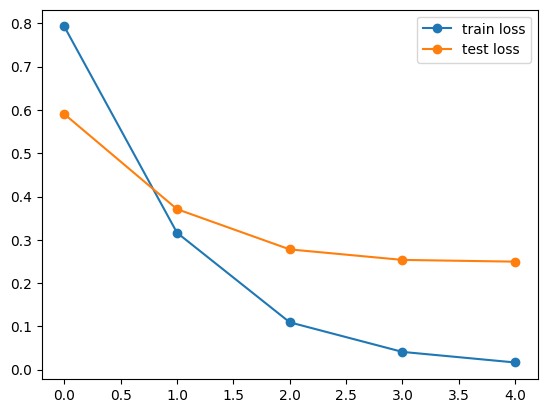

In [17]:
plt.plot(train_losses, 'o-', label='train loss')
plt.plot(test_losses, 'o-', label='test loss')
plt.legend();

### Metrics

In [18]:
def calc_embedding(id):
    return embedder(torch.tensor([id2idx[id]])).detach().numpy()[0]

In [19]:
df = df.merge(playlists_df,
                   left_on='playlist_id',
                   right_index=True)

df['embedding'] = df['track_id'].apply(lambda id: tuple(calc_embedding(id)) if id in id2idx else None)
df = df.dropna()

In [20]:
faiss_df = df[['track_id', 'embedding']].drop_duplicates()
faiss_df['idx'] = list(range(faiss_df.shape[0]))
tracks_vecs = np.array(faiss_df['embedding'].to_list())

In [21]:
index = faiss.IndexFlat(dim)   
index.add(tracks_vecs)          
print(index.ntotal)

89988


In [22]:
def search_closest(vec, index, topn=N_TOP+1):
    dist, idx = index.search(np.array([vec]), topn)
    return idx[0]

In [23]:
faiss_df['pred_neighbours_idx'] = faiss_df \
                                    .apply(lambda r: search_closest(r['embedding'], index), axis=1)

faiss_idx2id = dict(zip(faiss_df.idx, faiss_df.track_id))

faiss_df['pred_neighbours_id'] = faiss_df['pred_neighbours_idx'] \
                                    .apply(lambda neighbours: [faiss_idx2id[n] for n in neighbours])

In [24]:
df = df.merge(faiss_df[['track_id', 'pred_neighbours_id']], on='track_id')
df['neighbours'] = df.apply(lambda r: [n for n in r['neighbours'] if n != r['track_id']], axis=1)
df['pred_neighbours_id'] = df.apply(lambda r: [n for n in r['pred_neighbours_id'] if n != r['track_id']], axis=1)

In [25]:
def precision_at_k(true, pred):
    return len(set(pred) & set(true)) / len(pred)


def recall_at_k(true, pred):
    return len(set(pred) & set(true)) / len(true)


triplet_precision = df.apply(lambda r: precision_at_k(r['neighbours'], r['pred_neighbours_id']), axis=1).mean()
triplet_recall = df.apply(lambda r: recall_at_k(r['neighbours'], r['pred_neighbours_id']), axis=1).mean()

In [26]:
print("Triplet precision: {:.6f}".format(triplet_precision))
print("Triplet recall: {:.6f}".format(triplet_recall))

Triplet precision: 0.005081
Triplet recall: 0.000932


### Validation

In [27]:
id2name = {}
for i, t in df[['track_id', 'artist_name', 'track_name']].drop_duplicates().iterrows():
    id2name[t['track_id']] = [t['artist_name'], t['track_name']]

In [28]:
def search_track_id(track, artist):
    return df[df['artist_name'].str.contains(track) & 
              df['track_name'].str.contains(artist)].iloc[0]['track_id']


def similar_tracks(track, artist):
    target_id = search_track_id(track, artist)
    target_vec = df[df['track_id'] == target_id].iloc[0]['embedding']
    return [id2name[faiss_idx2id[idx]] for idx in search_closest(target_vec, index, 10+1)[1:]]

In [29]:
similar_tracks("The xx", "Intro")

[['Sasha Baron Cohen', 'Beggars At The Feast'],
 ['Tommy', 'Firefight'],
 ['Glass Cloud', 'Ivy & Wine'],
 ['Kevin Dubrow', 'Rock Rock (Till You Drop)'],
 ['All Sons & Daughters', 'Oh Our Lord'],
 ['Deerhunter', 'Living My Life'],
 ['Usher', "Hey Daddy (Daddy's Home)"],
 ['Ben Folds', 'Still'],
 ['Erotic Massage Music Ensemble', 'Mental Health'],
 ['Wolfgang Amadeus Mozart',
  'Piano Concerto No.21 in C Major, K.467: 1. Allegro']]

In [30]:
similar_tracks("Daft Punk", "One More Time")

[['emune', 'I Walked Away Cause She Looked Too Friendly'],
 ['PJ Harvey', 'Who The Fuck?'],
 ['Arcangel', 'Me Prefieres A Mi - Remix'],
 ['Tom Waits', 'Come On Up To The House'],
 ['Gadiel Espinoza', 'A El Alto Y Sublime'],
 ['Zombie Nation', 'Kernkraft 400 - DJ Gius Mix, Radio Edit'],
 ['Natalia Lafourcade', 'Tú Sí Sabes Quererme'],
 ['Video Games Live', 'Chrono Cross - "Scars of Time"'],
 ['Flatsound', "Don't Call Me At All"],
 ['Mannheim Steamroller', 'God Rest Ye, Merry Gentlemen']]

In [31]:
similar_tracks("Nirvana", "Come As You Are")

[['Wes Walker', 'Jordan Belfort'],
 ['Ryan Montbleau', 'The Boat Song'],
 ['Migos', 'Kelly Price (feat. Travis Scott)'],
 ['Andy Grammer', 'Fresh Eyes'],
 ['LMFAO', 'Party Rock Anthem'],
 ['Pitbull', 'Greenlight'],
 ['Disclosure', 'Omen - Dillon Francis Remix'],
 ['The Chainsmokers', 'Paris'],
 ['The Piano Guys', 'Hello / Lacrimosa'],
 ['DRAM', 'Broccoli (feat. Lil Yachty)']]

In [32]:
similar_tracks("Beatles", "Yesterday")

[['David Guetta', 'Little Bad Girl (feat. Taio Cruz & Ludacris)'],
 ['Edward Sharpe & The Magnetic Zeros', "That's What's Up"],
 ['Koh Lantana', 'Meditation: Healing Reiki'],
 ['Creedence Clearwater Revival', 'Good Golly Miss Molly'],
 ['Billy Zane', "Wait 'Til He Sees You"],
 ['Adam Doleac', 'Shady'],
 ['Brooke Sunny Moriber', 'The Factory Girls / Come Up to My Office'],
 ['Common', 'The Light'],
 ['The Jackson 5', 'Give Love On Christmas Day'],
 ['Crystal Castles', 'Affection']]

In [33]:
similar_tracks("Olive", "You're Not Alone")

[['Lizz Wright', 'When I Fall'],
 ['Los Tigres Del Norte', 'Jefe De Jefes'],
 ['Wiz Taylor', 'Mezmorized'],
 ['Kristin Chenoweth', 'Knowing When to Leave'],
 ['Chino & Nacho', 'Voy A Caer En La Tentación'],
 ['Emmanuel',
  'La Chica De Humo - En Vivo Desde Auditorio Nacional, México/ 2007'],
 ["Howlin' Wolf", 'Spoonful'],
 ['The Irish Rovers', 'Bonnie Kellswater'],
 ['NOFX', "Don't Call Me White"],
 ['Moxie Raia', 'Healer']]